### Notebook to plot mean vertical profiles of vertical motion and other variables from WRF model output for new stratiform paper.

James Ruppert  
jruppert@ou.edu  
7/11/24

### Main settings

In [4]:
import numpy as np
from matplotlib import ticker, rc
import matplotlib.pyplot as plt
import sys
from scipy import stats
import pandas as pd
from thermo_functions import *
from precip_class import *
from memory_usage import *
from read_functions import *
import pickle

In [5]:
# #### Main settings

storm = 'haiyan'
# storm = 'maria'

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
datdir2 = 'post/d02/'
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
# main = "/Users/jamesruppert/code/tc_postproc/"
# main_pickle = main+storm+'/'
figdir = "/home/jamesrup/figures/tc/ens/boxplot/"

# Pickle files retain time dimension out to 24
t1_file=24

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 3
enstag = str(nmem)

In [6]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
test_str='ctl'
datdir = main+storm+'/'+memb_all[0]+'/'+test_str+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
# datdir = main
# nt_data, nz, nx1, nx2 = get_file_dims(datdir)
nt=t1_file
# dp = (pres[1]-pres[0])*1e2 # Pa
nx1-=80*2
nx2-=80*2
# Setting for (vertical) HiRes output
nz=39
pres = np.arange(1000,25,-25)
dp = (pres[0]-pres[1])*1e2 # Pa

In [7]:
# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','CONVOFF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']

ntest = len(tests)

# 0-5: pclass 0-5
# 6: pclass=1,4,5 (deep conv + strat + anvil)
# 7 = where PW ≥ 48 (Mapes et al. 2018)
# 8 = where PW < 48 (Mapes et al. 2018)
# 9 = whole domain
nmean=10
mean_str = ["Non-cloud", "Deep", "Cong", "Shallow", "Strat", "Anvil", 'MCS', 'Moist', 'Dry', 'All']
# imean_sel = [1,4,5,6,7,9]
imean_sel = [1,4,5,9]
nmean_sel = len(imean_sel)

### Read loop

In [8]:
# Main read loops for 3D (dependent) variables

# Arrays to save variables
dims = (nmem, ntest, nmean, nt, nz)
w    = np.zeros(dims)
rho  = np.zeros(dims)
qv   = np.zeros(dims)
tmpk = np.zeros(dims)
lw   = np.zeros(dims)
lwc  = np.zeros(dims)
sw   = np.zeros(dims)
swc  = np.zeros(dims)

# Loop over ensemble members
for imemb in range(nmem):

    pickle_file = main_pickle+memb_all[imemb]+'/mean_profiles_'+str(t1_file)+'hrs.pkl'
    with open(pickle_file, 'rb') as file:
        iw_mean, irho_mean, iqv_mean, itmpk_mean, \
        ilw_mean, ilwc_mean, isw_mean, iswc_mean = pickle.load(file)
    w[imemb,:]    = iw_mean
    rho[imemb,:]  = irho_mean
    qv[imemb,:]   = iqv_mean
    tmpk[imemb,:] = itmpk_mean
    lw[imemb,:]   = ilw_mean
    lwc[imemb,:]  = ilwc_mean
    sw[imemb,:]   = isw_mean
    swc[imemb,:]  = iswc_mean

In [9]:
# Vertical integral function
def calc_vint(invar, pres, dp):
    # Note: pres is in hPa, dp in Pa
    g = 9.81 # m/s2
    p_top = 100 # hPa, integration top
    ik_sum = np.where(pres >= p_top)
    var_vint = np.sum(invar[...,0:np.max(ik_sum)+1], axis=-1)*dp/g
    return var_vint

In [10]:
# Vertical integrated mass flux
vmf = calc_vint(w, pres, dp)

### Plotting

#### Plot functions

In [11]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

In [12]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    # conf_set=0.95 # Confidence interval to apply throughout
    conf_set=0.9 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

In [13]:
def calculate_ddt(pltvar, it_max):

    # Using time-derivative
    pltvar_ddt = np.gradient(pltvar[...,0:it_max,:], axis=-2)

    # Using time-regression
    time_array = np.arange(it_max)
    dims=(nmem,ntest,nmean,nz)
    pltvar_regress = np.zeros(dims)
    for imemb in range(nmem):
        for itest in range(ntest):
            for imean in range(nmean):
                for iz in range(nz):
                    slope, intercept, r, p, se = stats.linregress(time_array, pltvar[imemb,itest,imean,0:it_max,iz])
                    pltvar_regress[imemb,itest,imean,iz] = slope

    # Average over ensemble members
    pltvar_ddt = np.mean(pltvar_ddt, axis=(0,3))
    pltvar_regress = np.mean(pltvar_regress, axis=0)

    return pltvar_ddt, pltvar_regress

#### Time series

#### Vertical profiles

##### Select plot variable

In [14]:
# Plot variable

# pltvar = w*rho
# units = 'kg/m$^2$/s'
# var_tag = 'VMF'

# thv = theta_virtual(tmpk, qv, pres[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]*1e2)
# pltvar = thv
# units = 'K'
# var_tag = r'$\theta_v$'

the = theta_equiv(tmpk, qv, qv, pres[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]*1e2)
pltvar = the
units = 'K'
var_tag = r'$\theta_e$'

# pltvar = (lw - lwc) * (24*3600) # K/s --> K/d
# units = 'K/d'
# var_tag = 'LWCRF'

In [15]:
# Average profiles over time
# it_max=24
it_max=6
pltvar_tavg = np.mean(pltvar[...,0:it_max,:], axis=3)

In [16]:
# # for imean in range(nmean):
# for iimean in range(nmean_sel):

#     imean = imean_sel[iimean]

#     # create figure
#     # fig = plt.figure(figsize=(10,5))
#     fig = plt.figure(figsize=(6,5))
#     ax = fig.add_subplot(111)

#     ax.set_title(var_tag+' ('+mean_str[imean]+')')
#     ax.set_ylabel('Pressure [hPa]')

#     ax.invert_yaxis()
#     ax.set_yscale('log')

#     linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
#     linecolor=['red', 'blue', 'green', 'yellow', 'orange']

#     ctl_ensmean = np.mean(pltvar_tavg[:,0,:,:], axis=0)
#     pltvar_tavg_anom = pltvar_tavg - ctl_ensmean[np.newaxis,...]
#     for itest in range(ntest):
#         # mean, low, high = mean_confidence_interval(w_tavg[:,itest,imean,:])
#         mean, low, high = mean_confidence_interval(pltvar_tavg_anom[:,itest,imean,:])
#         plt.fill_betweenx(pres, low, high, alpha=0.2, color=linecolor[itest])
#         plt.plot(mean, pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])

#     ax.set_ylim(1000, 100)
#     ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#     ax.yaxis.set_minor_formatter(ticker.ScalarFormatter())

#     plt.axvline(x=0,color='k',linewidth=0.5)
#     ax.set_xlabel(units)
#     # vmax=0.04
#     # plt.xlim(-1*vmax,vmax)
#     plt.legend(loc="upper right")

#     plt.show()

##### Profile time dependency

In [17]:
pltvar_ddt, pltvar_regress = calculate_ddt(pltvar, it_max)

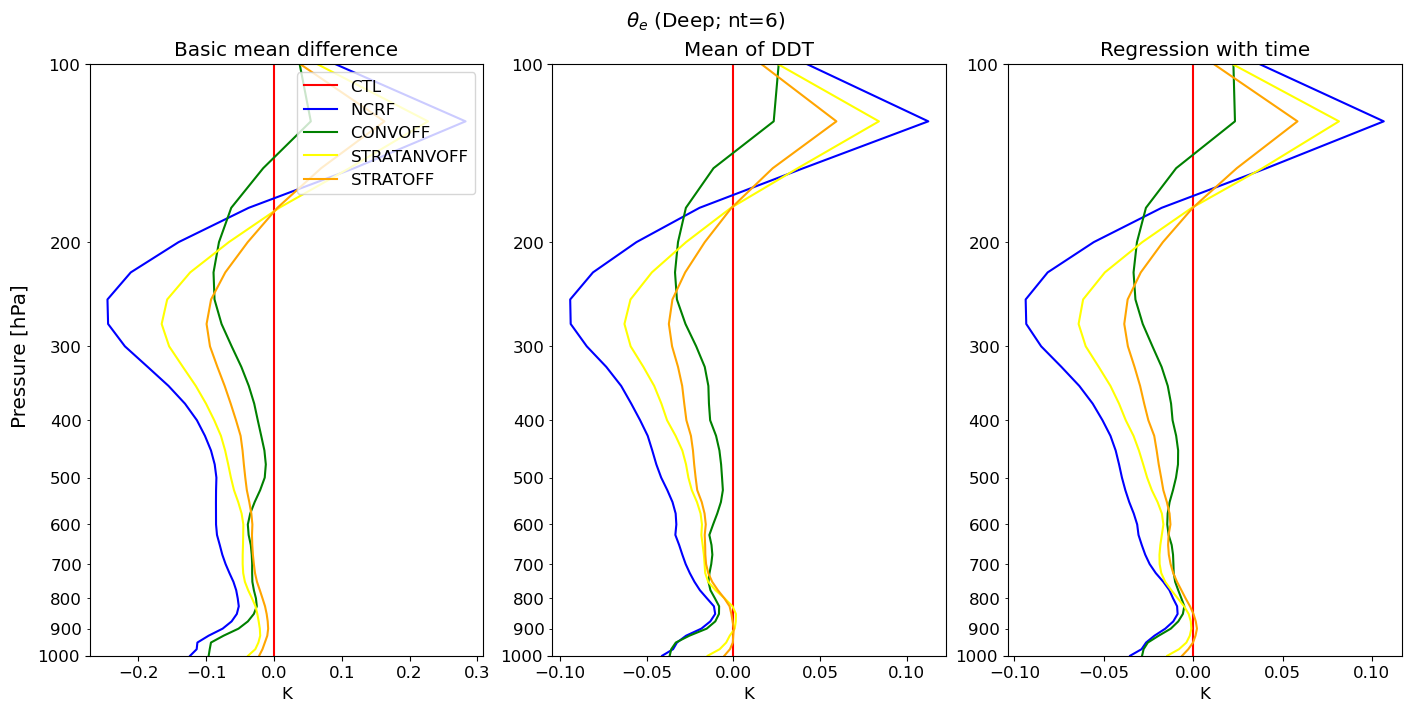

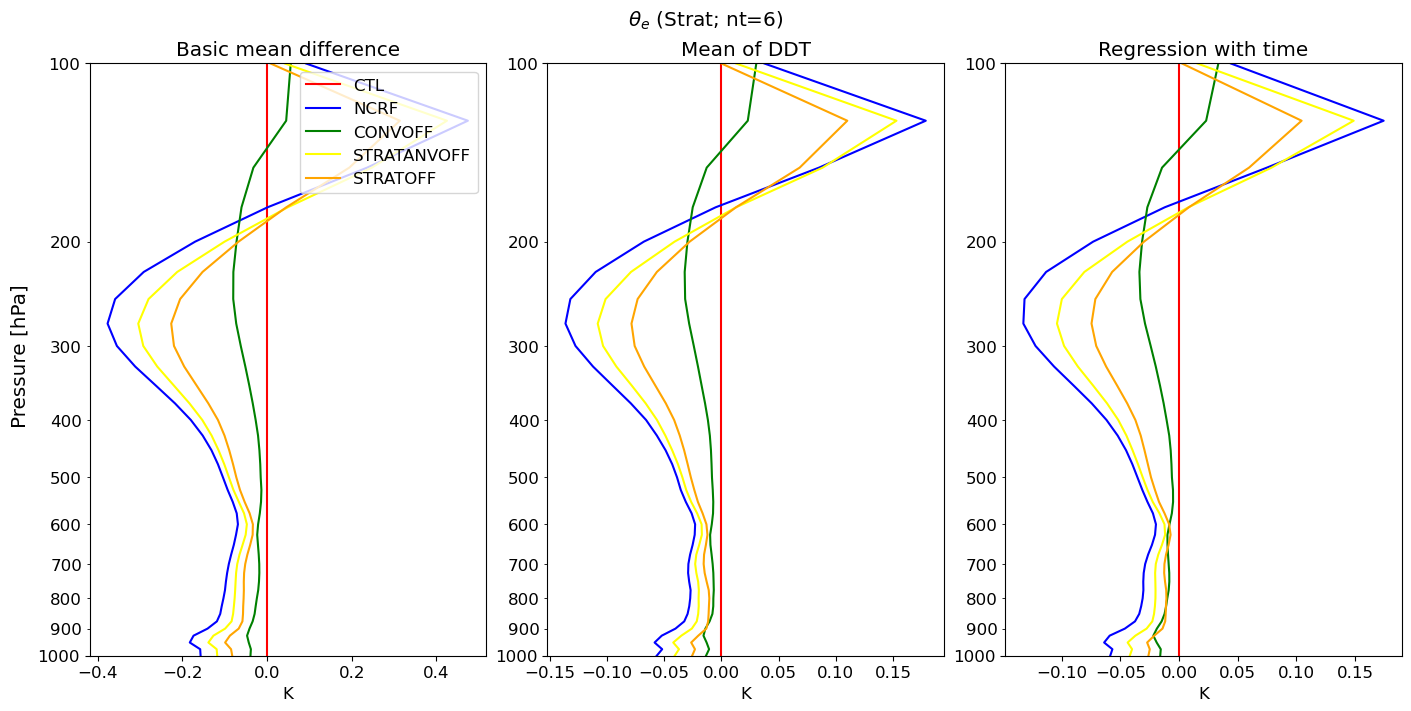

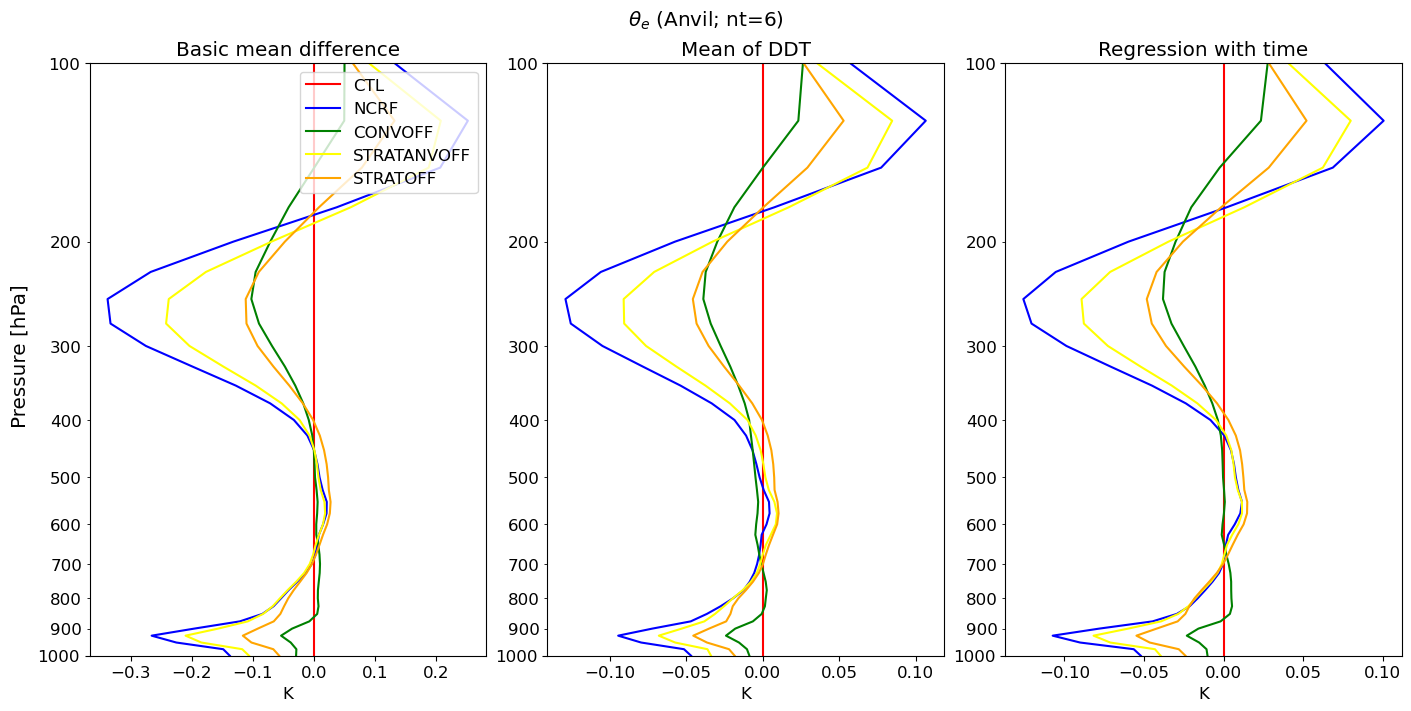

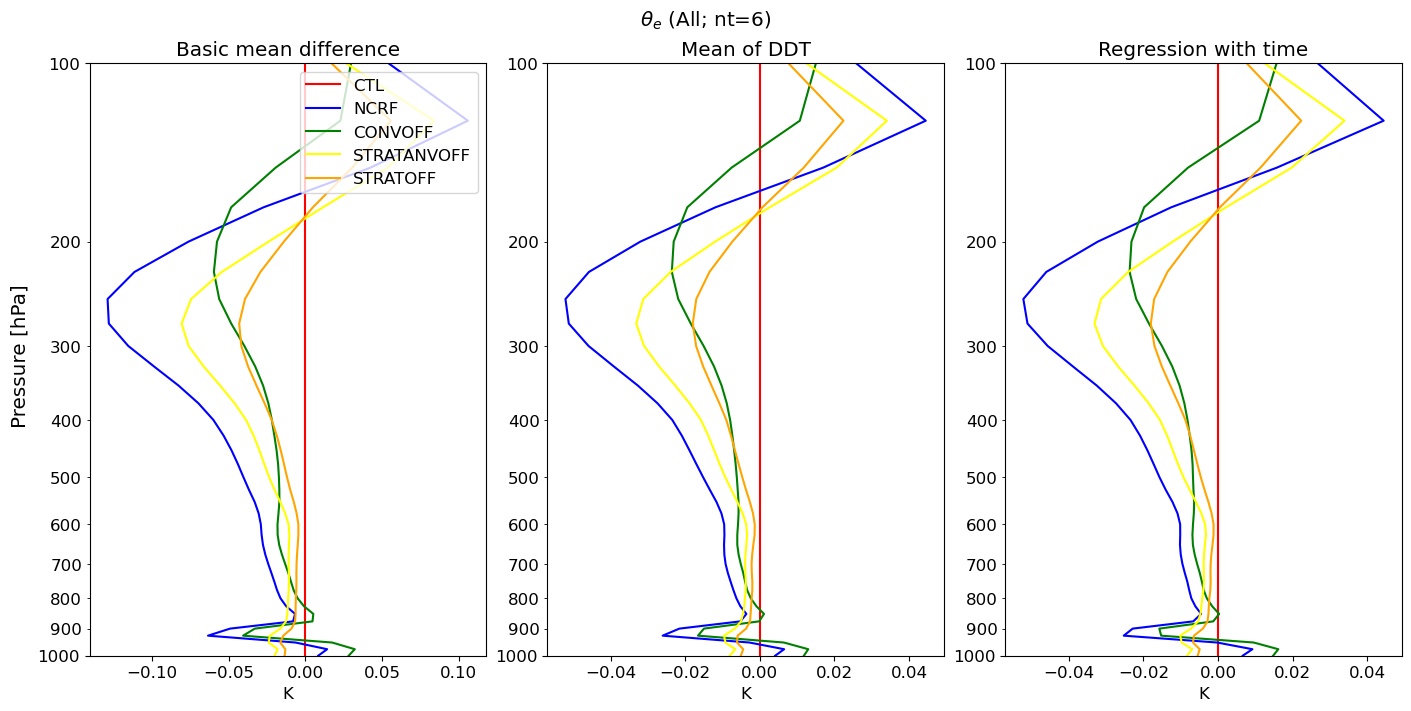

In [18]:
# for imean in range(nmean):
for iimean in range(nmean_sel):

    imean = imean_sel[iimean]

    # create figure
    fig, ax = plt.subplots(1,3, figsize=(14,7), layout="constrained",) # row, column
            # width_ratios=[5,2,5,2,5,2])
    # fig = plt.figure(figsize=(6,5))
    # ax = fig.add_subplot(111)

    fig.suptitle(var_tag+' ('+mean_str[imean]+'; nt='+str(it_max)+')')
    fig.supylabel('Pressure [hPa]')

    for iax in ax:
        iax.invert_yaxis()
        iax.set_yscale('log')
        iax.set_ylim(1000, 100)
        iax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        iax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
        iax.axvline(x=0,color='k',linewidth=0.5)
        iax.set_xlabel(units)
    # vmax=0.04
    # plt.xlim(-1*vmax,vmax)

    linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
    linecolor=['red', 'blue', 'green', 'yellow', 'orange']

    ctl_ensmean = np.mean(pltvar_tavg[:,0,:,:], axis=0)
    pltvar_tavg_anom = pltvar_tavg - ctl_ensmean[np.newaxis,...]

    ctl_ddt_ensmean = pltvar_ddt[0,:,:]
    w_anom1 = pltvar_ddt - ctl_ddt_ensmean[np.newaxis,...]
    ctl_ddt_ensmean = pltvar_regress[0,:,:]
    w_anom2 = pltvar_regress - ctl_ddt_ensmean[np.newaxis,...]

    for itest in range(ntest):
        mean, low, high = mean_confidence_interval(pltvar_tavg_anom[:,itest,imean,:])
        # ax[0].fill_betweenx(pres, low, high, alpha=0.2, color=linecolor[itest])
        ax[0].plot(mean, pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
        ax[1].plot(w_anom1[itest,imean], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
        ax[2].plot(w_anom2[itest,imean], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
        ax[0].set_title('Basic mean difference')
        ax[1].set_title('Mean of DDT')
        ax[2].set_title('Regression with time')

    ax[0].legend(loc="upper right")

    plt.show()

##### Difference from ALL

In [19]:
pltvar_allmean = pltvar[:,:,9,...]
pltvar_anom = pltvar - pltvar_allmean[:,:,np.newaxis,:,:]

In [20]:
pltvar = pltvar_anom
units = 'K'
var_tag = r"$\theta_e'$"

# Average profiles over time
# it_max=24
# it_max=6
pltvar_tavg = np.mean(pltvar[...,0:it_max,:], axis=3)

In [21]:
pltvar_ddt, pltvar_regress = calculate_ddt(pltvar, it_max)

In [22]:
# # for imean in range(nmean):
# for iimean in range(nmean_sel):

#     imean = imean_sel[iimean]

#     # create figure
#     fig, ax = plt.subplots(1,3, figsize=(14,7), layout="constrained",) # row, column
#             # width_ratios=[5,2,5,2,5,2])
#     # fig = plt.figure(figsize=(6,5))
#     # ax = fig.add_subplot(111)

#     fig.suptitle(var_tag+' ('+mean_str[imean]+'; nt='+str(it_max)+')')
#     fig.supylabel('Pressure [hPa]')

#     for iax in ax:
#         iax.invert_yaxis()
#         iax.set_yscale('log')
#         iax.set_ylim(1000, 100)
#         iax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#         iax.yaxis.set_minor_formatter(ticker.ScalarFormatter())
#         iax.axvline(x=0,color='k',linewidth=0.5)
#         iax.set_xlabel(units)
#     # vmax=0.04
#     # plt.xlim(-1*vmax,vmax)

#     linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
#     linecolor=['red', 'blue', 'green', 'yellow', 'orange']

#     ctl_ensmean = np.mean(pltvar_tavg[:,0,:,:], axis=0)
#     pltvar_tavg_anom = pltvar_tavg - ctl_ensmean[np.newaxis,...]

#     ctl_ddt_ensmean = pltvar_ddtmn1[0,:,:]
#     w_anom1 = pltvar_ddtmn1 - ctl_ddt_ensmean[np.newaxis,...]
#     ctl_ddt_ensmean = pltvar_ddtmn2[0,:,:]
#     w_anom2 = pltvar_ddtmn2 - ctl_ddt_ensmean[np.newaxis,...]

#     for itest in range(ntest):
#         mean, low, high = mean_confidence_interval(pltvar_tavg_anom[:,itest,imean,:])
#         ax[0].fill_betweenx(pres, low, high, alpha=0.2, color=linecolor[itest])
#         ax[0].plot(mean, pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#         ax[1].plot(w_anom1[itest,imean], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#         ax[2].plot(w_anom2[itest,imean], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
#         ax[0].set_title('Basic mean difference')
#         ax[1].set_title('Mean of DDT')
#         ax[2].set_title('Regression with time')

#     ax[0].legend(loc="upper right")

#     plt.show()

##### Profiles all variables

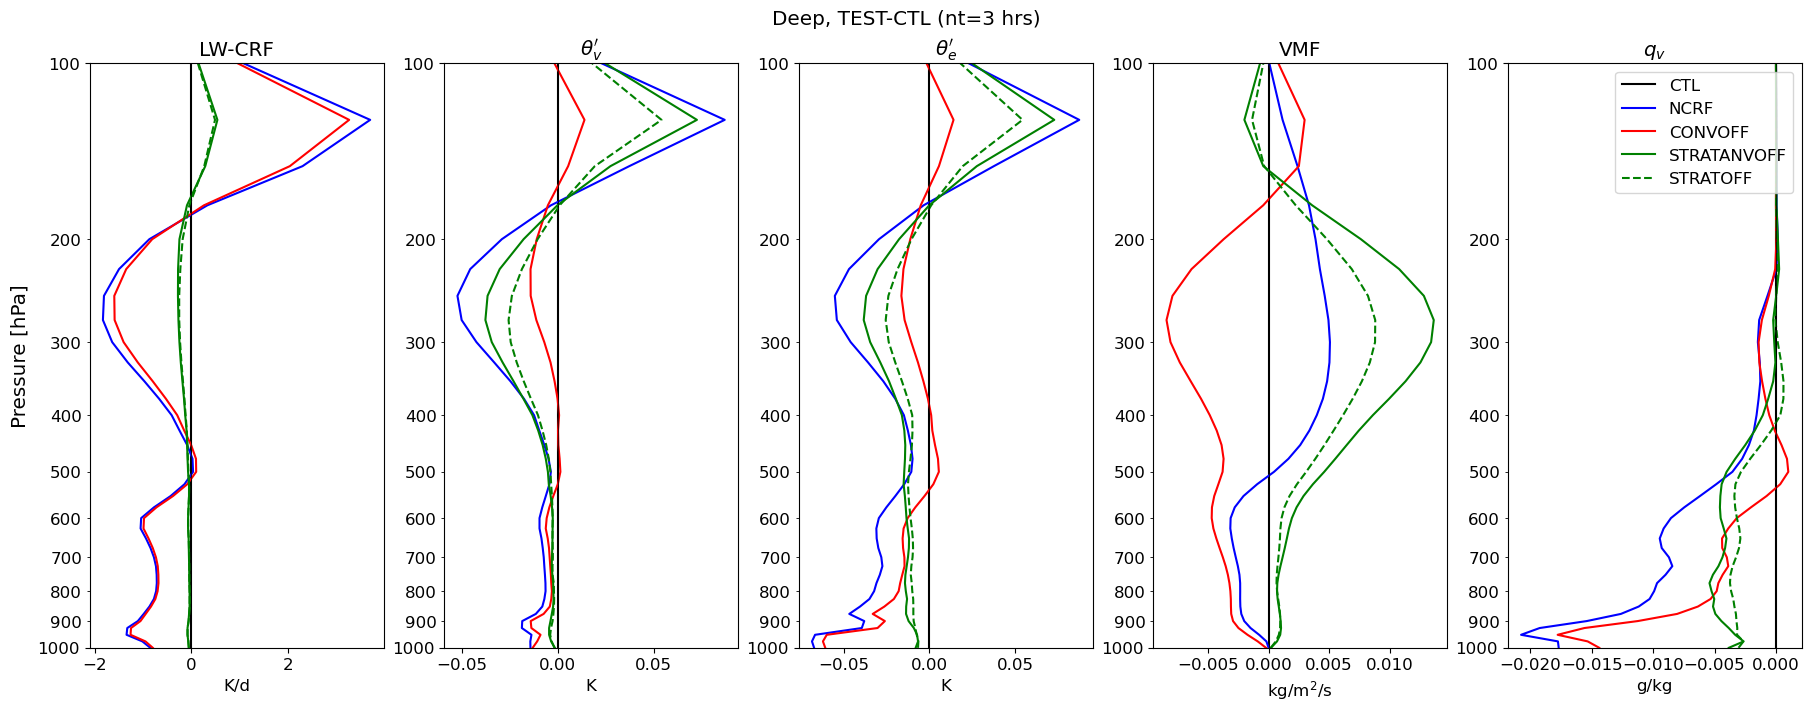

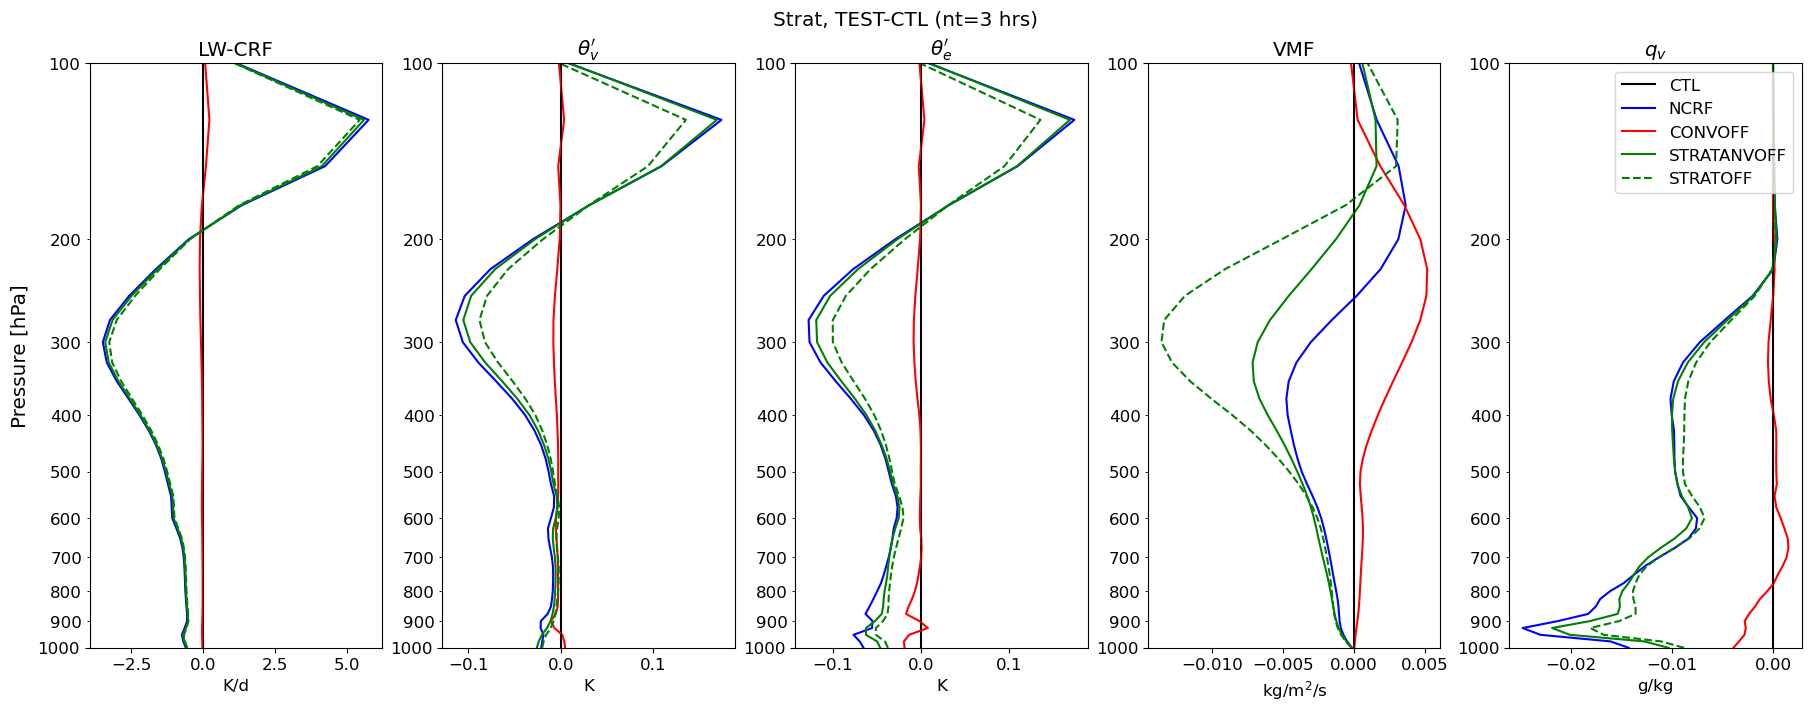

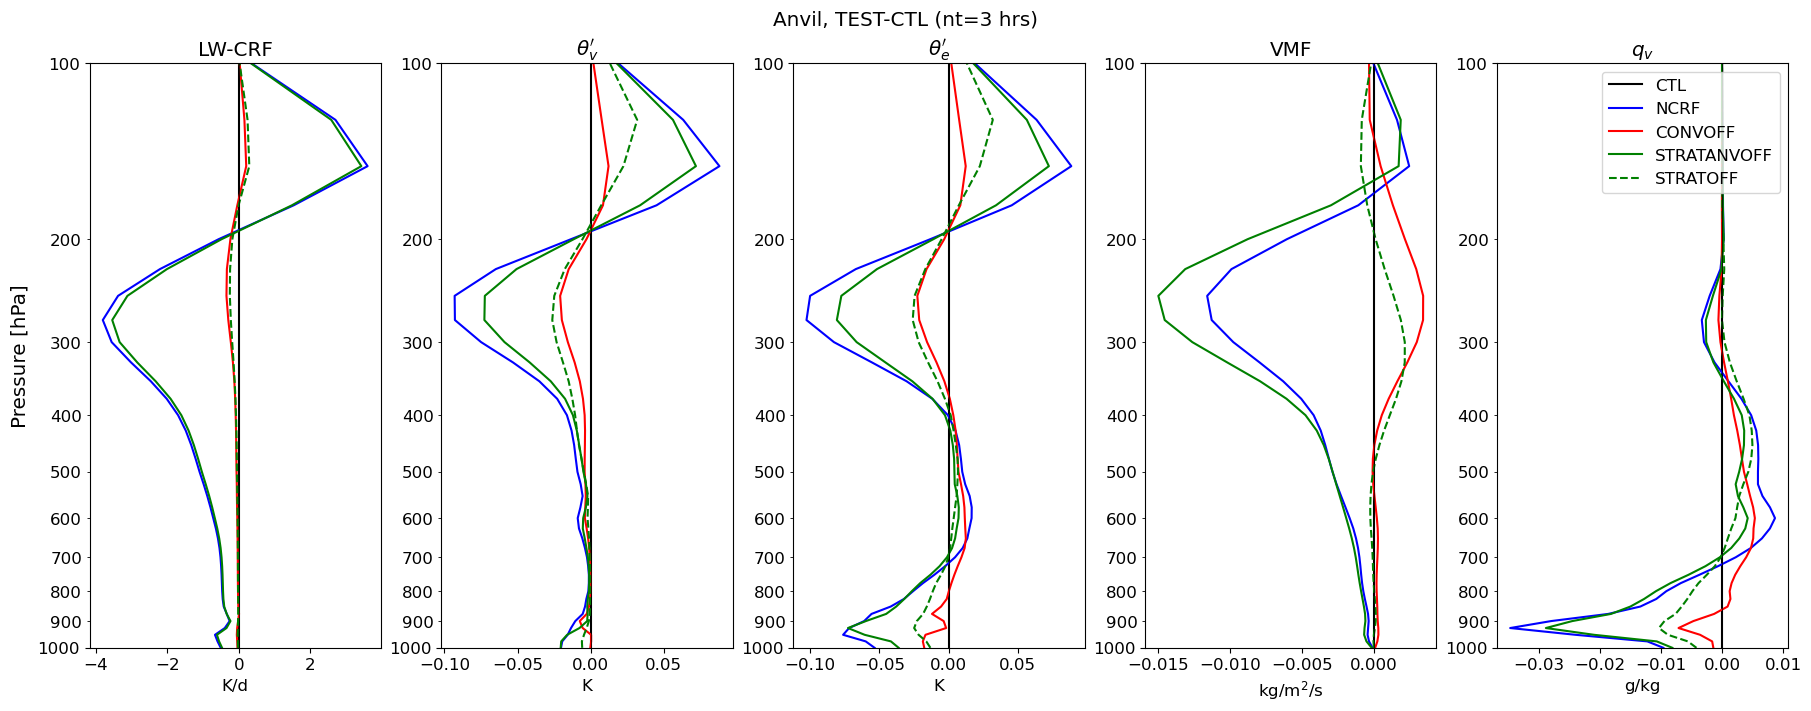

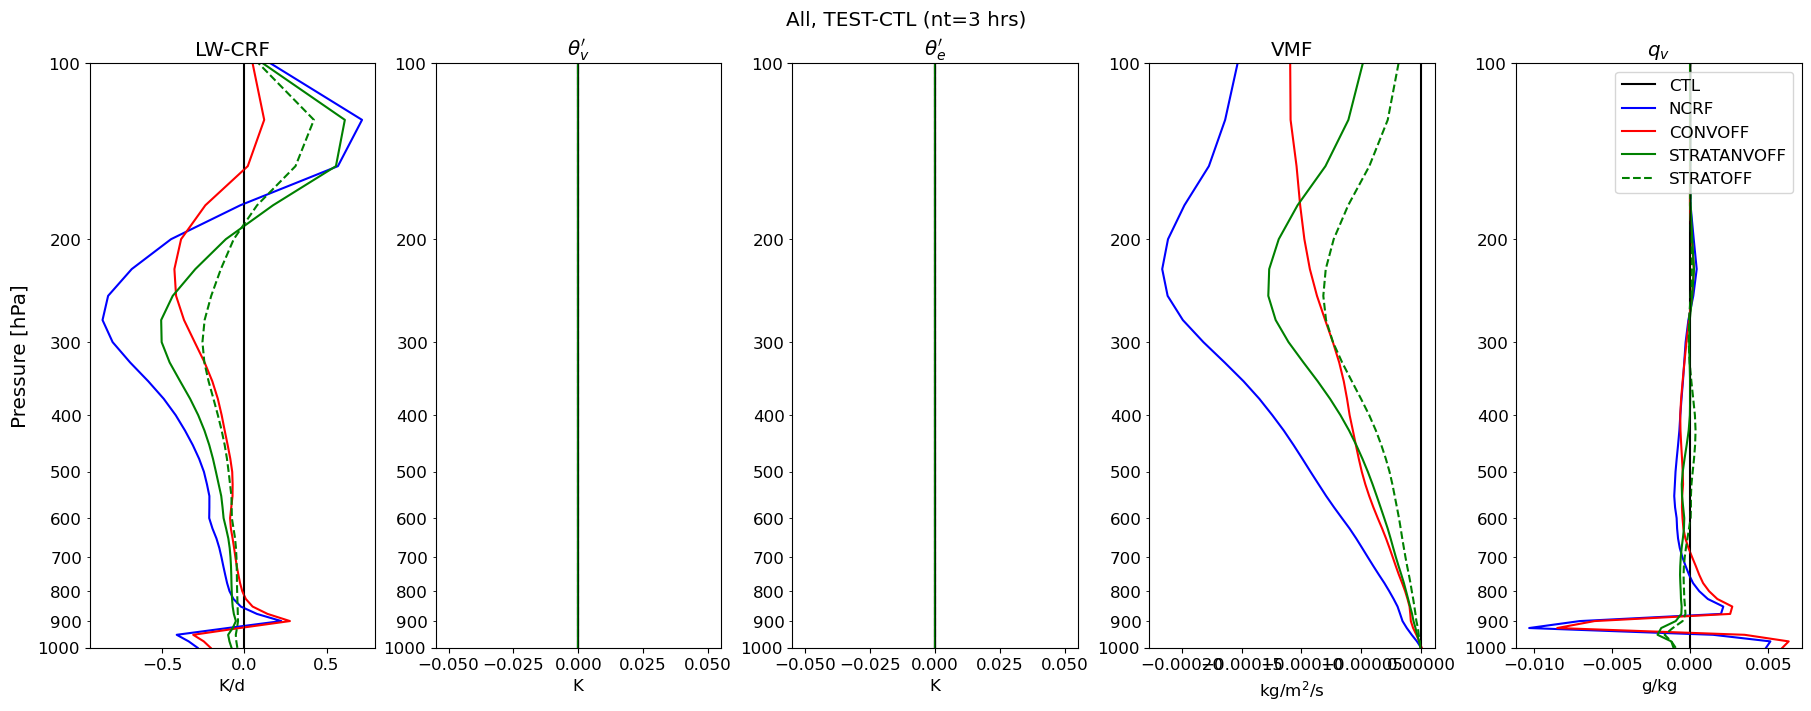

In [23]:
subtract_all = True
# subtract_all = False

ctlanom = True
# ctlanom = False

# Plot variable

it_max = 3

# vmf = w*rho
vmf = w
thv = theta_virtual(tmpk, qv, pres[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]*1e2)
the = theta_equiv(tmpk, qv, qv, pres[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]*1e2)
lwcrf = (lw - lwc) * (24*3600) # K/s --> K/d

all_vars = np.array([lwcrf, thv, the, vmf, qv*1e3])
nprof = all_vars.shape[0]
subtitles = ['LW-CRF', r'$\theta_v$', r'$\theta_e$', 'VMF', '$q_v$']
units     = ['K/d', 'K', 'K', 'kg/m$^2$/s', 'g/kg']

# Subtract ALL-MEAN
if subtract_all:
    pltvar_allmean = all_vars[...,9,:,:]
    # all_vars -= pltvar_allmean[...,np.newaxis,:,:]
    all_vars[1,...] -= pltvar_allmean[1,...,np.newaxis,:,:] # THV
    all_vars[2,...] -= pltvar_allmean[2,...,np.newaxis,:,:] # THE
    subtitles[1] = r"$\theta_v'$"
    subtitles[2] = r"$\theta_e'$"

# # Get DDT, Regression
# dims = (nprof, ntest, nmean, nz)
# all_vars_ddt = np.zeros(dims)
# all_vars_regress = np.zeros(dims)
# for ivar in range(nprof):
#     ipltvar_ddt, ipltvar_regress = calculate_ddt(all_vars[ivar], it_max)
#     all_vars_ddt[ivar,...]     = ipltvar_ddt
#     all_vars_regress[ivar,...] = ipltvar_regress

for iimean in range(nmean_sel):
# for iimean in range(2):

    imean = imean_sel[iimean]
    all_vars_imean = all_vars[...,imean,:,:]
    # all_vars_ddt_imean = all_vars_ddt[:,:,imean,:]
    # all_vars_regress_imean = all_vars_regress[:,:,imean,:]

    # create figure
    # fig_x = 14
    fig_x = 18
    fig, ax = plt.subplots(1,nprof, figsize=(fig_x,7), layout="constrained",) # row, column

    # if subtract_all:
    #     title = mean_str[imean]+'-ALL (nt='+str(it_max)+')'
    # else:
    if ctlanom:
        title = mean_str[imean]+', TEST-CTL (nt='+str(it_max)+' hrs)'
    else:
        title = mean_str[imean]+' (nt='+str(it_max)+' hrs)'

    fig.suptitle(title)
    fig.supylabel('Pressure [hPa]')

    linecolor=['black', 'blue', 'red', 'green', 'green']
    linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
    linestyle[-1]='dashed'

    for iprof in range(nprof):

        # Compute means and time tendencies
        # Basic mean/anomaly from CTL
        pltvar = all_vars_imean[iprof]
        pltvar_tavg = np.mean(pltvar[...,0:it_max,:], axis=2)
        ctl_ensmean = np.mean(pltvar_tavg[:,0,:], axis=0)
        if ctlanom:
            pltvar_tavg = pltvar_tavg - ctl_ensmean[np.newaxis,np.newaxis,:]
            # pltvar_tavg = ctl_ensmean[np.newaxis,np.newaxis,:] - pltvar_tavg

        # # DDT
        # pltvar_ddt = all_vars_ddt_imean[iprof]
        # # print(pltvar_ddt.shape)
        # ctl_ddt = pltvar_ddt[0,:]
        # pltvar_ddt -= ctl_ddt[np.newaxis,:]
        # # REGRESS
        # pltvar_regress = all_vars_regress_imean[iprof]
        # ctl_regress = pltvar_regress[0,:]
        # pltvar_regress -= ctl_regress[np.newaxis,:]

        # Plot all sensitivity tests for variable
        for itest in range(ntest):

            # Basic means with confidence intervals
            mean, low, high = mean_confidence_interval(pltvar_tavg[:,itest])
            ax[iprof].plot(mean, pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            # if (itest == 0) or (itest == 1):
            #     ax[iprof].fill_betweenx(pres, low, high, alpha=0.2, color=linecolor[itest])

            # DDT
            # ax[iprof].plot(pltvar_ddt[itest], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])

            # REGRESS
            # ax[iprof].plot(pltvar_regress[itest], pres, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])

        ax[iprof].set_title(subtitles[iprof])
        ax[iprof].set_xlabel(units[iprof])
        ax[iprof].invert_yaxis()
        ax[iprof].set_yscale('log')
        ax[iprof].set_ylim(1000, 100)
        ax[iprof].yaxis.set_major_formatter(ticker.ScalarFormatter())
        ax[iprof].yaxis.set_minor_formatter(ticker.ScalarFormatter())
        ax[iprof].axvline(x=0,color='k',linewidth=0.5)

    ax[nprof-1].legend(loc="upper right")

    plt.show()

#### Time series all variables

In [24]:
# Vertical integral function
def calc_vavg(invar, pres, dp):
    # Note: pres is in hPa, dp in Pa
    g = 9.81 # m/s2
    p_top = 100 # hPa, integration top
    ik_sum = np.where(pres >= p_top)
    var_vavg = np.mean(invar[...,0:np.max(ik_sum)+1], axis=-1)#*dp
    return var_vavg

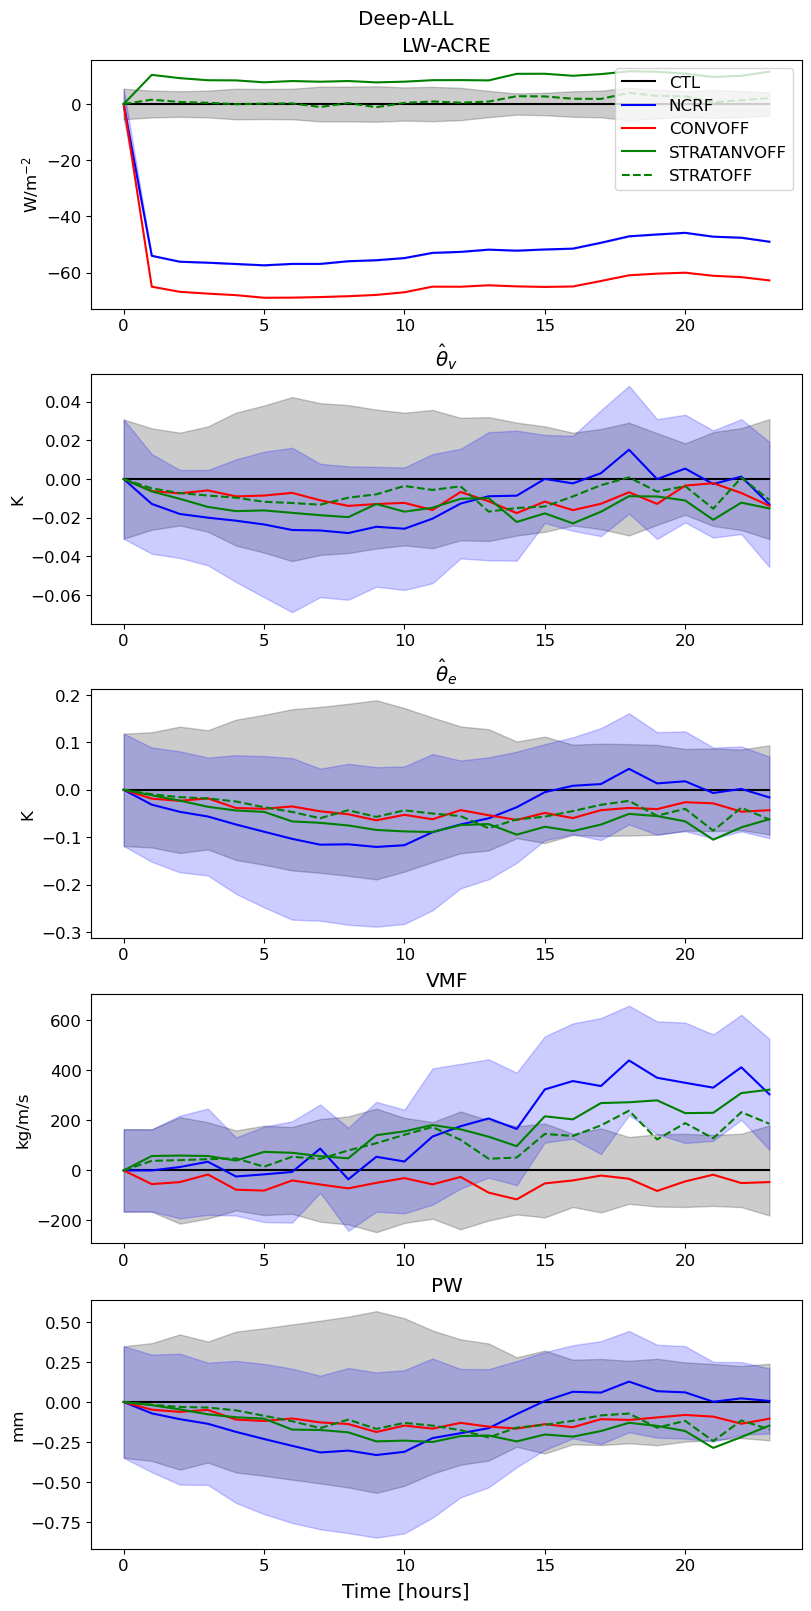

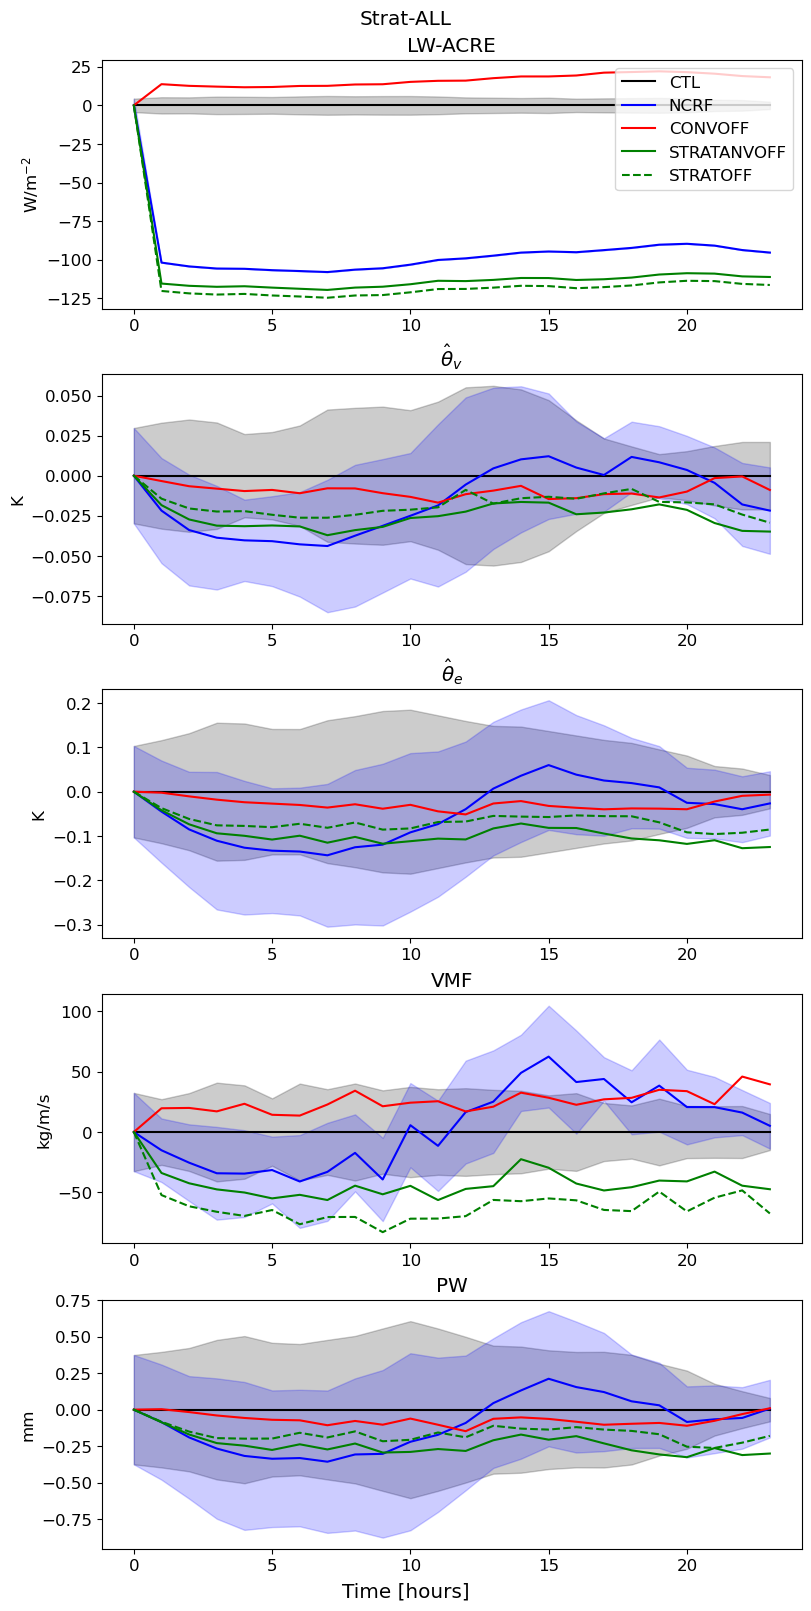

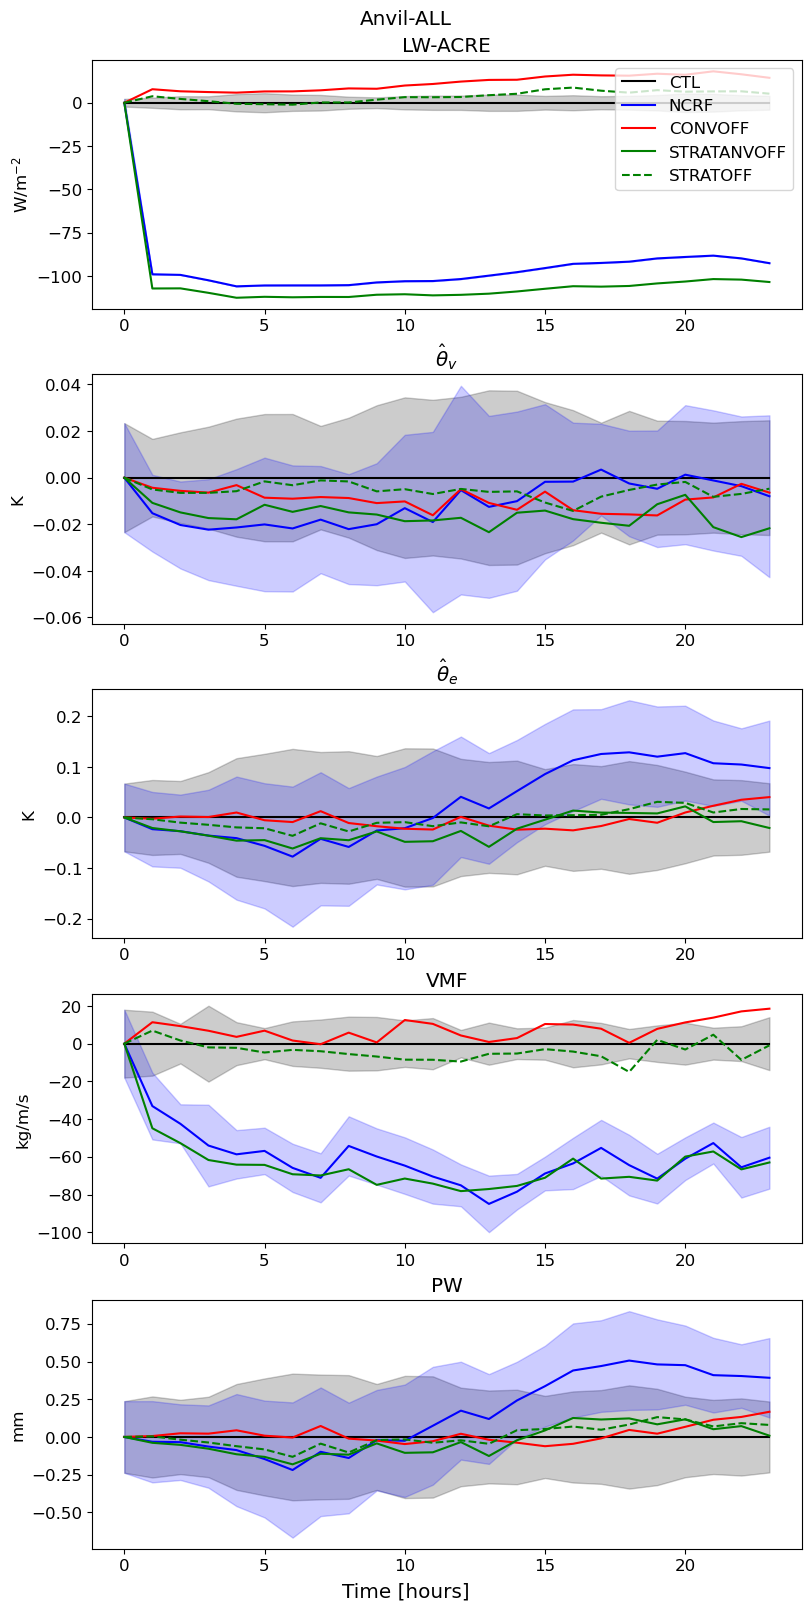

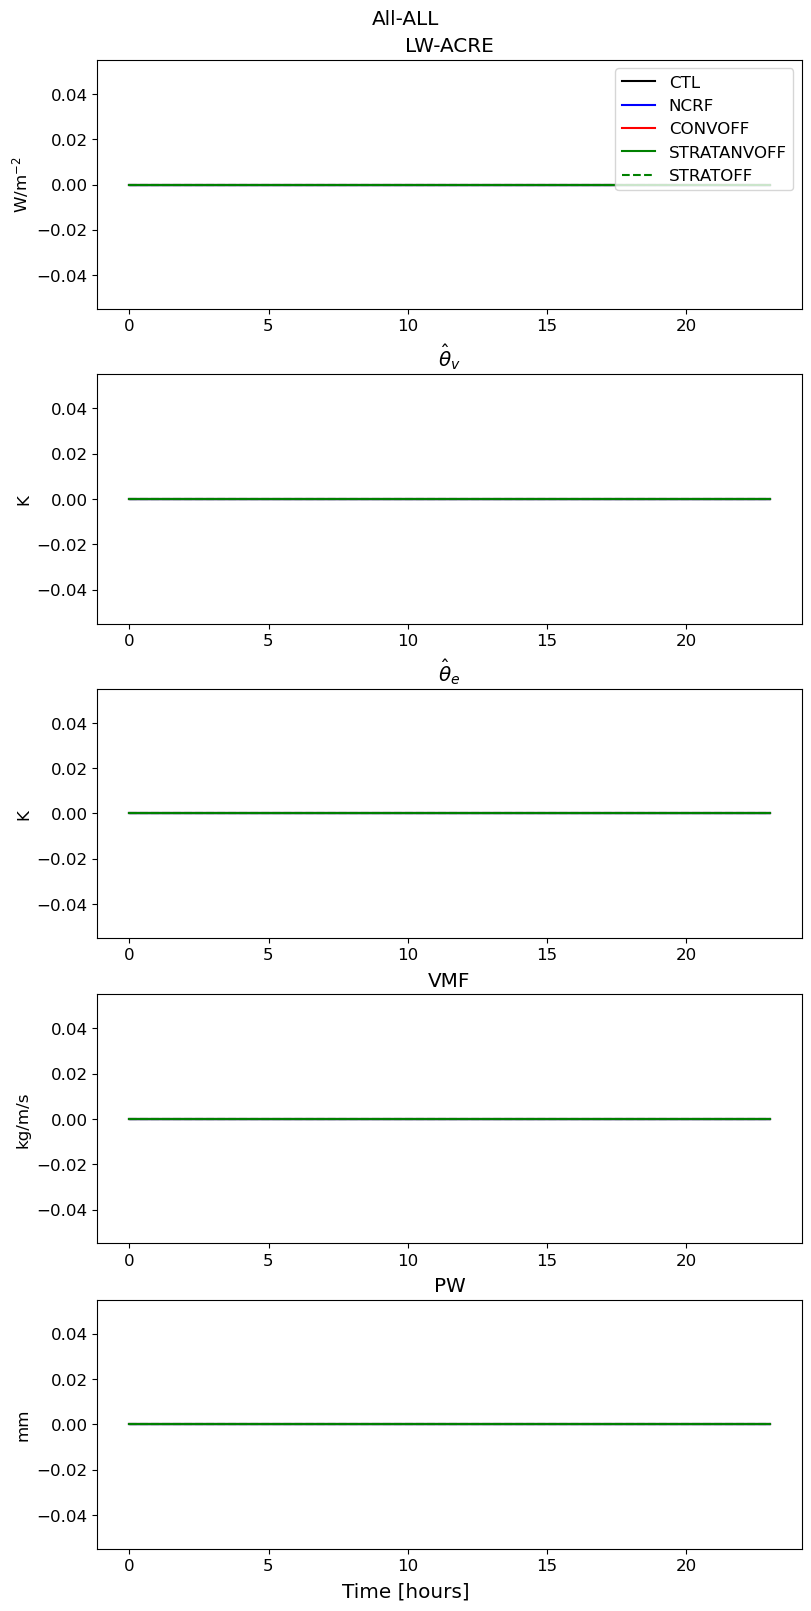

In [25]:
subtract_all = True
# subtract_all = False

# Variable list
thv = theta_virtual(tmpk, qv, pres[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]*1e2)
the = theta_equiv(tmpk, qv, qv, pres[np.newaxis, np.newaxis, np.newaxis, np.newaxis, :]*1e2)
thv_vavg = calc_vavg(thv, pres, dp)
the_vavg = calc_vavg(the, pres, dp)
cp=1004 # J/K/kg
lwcrf = (lw - lwc)*cp # K/s --> J/s/kg = W/kg

all_vars_vint = np.array([calc_vint(lwcrf, pres, dp),
                     thv_vavg,
                     the_vavg,
                     calc_vint(w, pres, dp),
                     calc_vint(qv, pres, dp)])

# Subtract ALL-MEAN
if subtract_all:
    pltvar_allmean = all_vars_vint[...,9,:]
    all_vars_vint -= pltvar_allmean[...,np.newaxis,:]

nprof = all_vars.shape[0]
subtitles = ['LW-ACRE', r'$\hat\theta_v$', r'$\hat\theta_e$', 'VMF', 'PW']
units     = ['W/m$^{-2}$', 'K', 'K', 'kg/m/s', 'mm']

for iimean in range(nmean_sel):

    print()
    imean = imean_sel[iimean]

    all_vars_imean = all_vars_vint[...,imean,:]

    # create figure
    fig_x = 8
    fig_y = 16
    fig, ax = plt.subplots(nprof,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column

    if subtract_all:
        title = mean_str[imean]+'-ALL'
    else:
        title = mean_str[imean]
    fig.suptitle(title)
    fig.supxlabel('Time [hours]')

    for iprof in range(nprof):

        pltvar = all_vars_imean[iprof]
        ctl_ensmean = np.mean(pltvar[:,0,:], axis=0)
        pltvar_anom = pltvar - ctl_ensmean[np.newaxis,np.newaxis,:]

        # Plot all sensitivity tests for variable
        for itest in range(ntest):

            # mean, low, high = mean_confidence_interval(pltvar[:,itest,:])
            mean, low, high = mean_confidence_interval(pltvar_anom[:,itest,:])
            ax[iprof].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            # var_smooth = pd.DataFrame(mean)
            # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
            # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            if (itest == 0) or (itest == 1):
                xdim = range(0,nt)
                ax[iprof].fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
                # low_smooth = pd.DataFrame(low)
                # low_smooth = low_smooth.rolling(window=3, center=True, closed='both').mean()
                # high_smooth = pd.DataFrame(high)
                # high_smooth = high_smooth.rolling(window=3, center=True, closed='both').mean()
                # ax[iprof].fill_between(xdim, np.squeeze(high_smooth), np.squeeze(low_smooth), alpha=0.2, color=linecolor[itest])

        ax[iprof].set_title(subtitles[iprof])
        ax[iprof].set_ylabel(units[iprof])

    ax[0].legend(loc="upper right")

    plt.show()

#### Time series of moisture

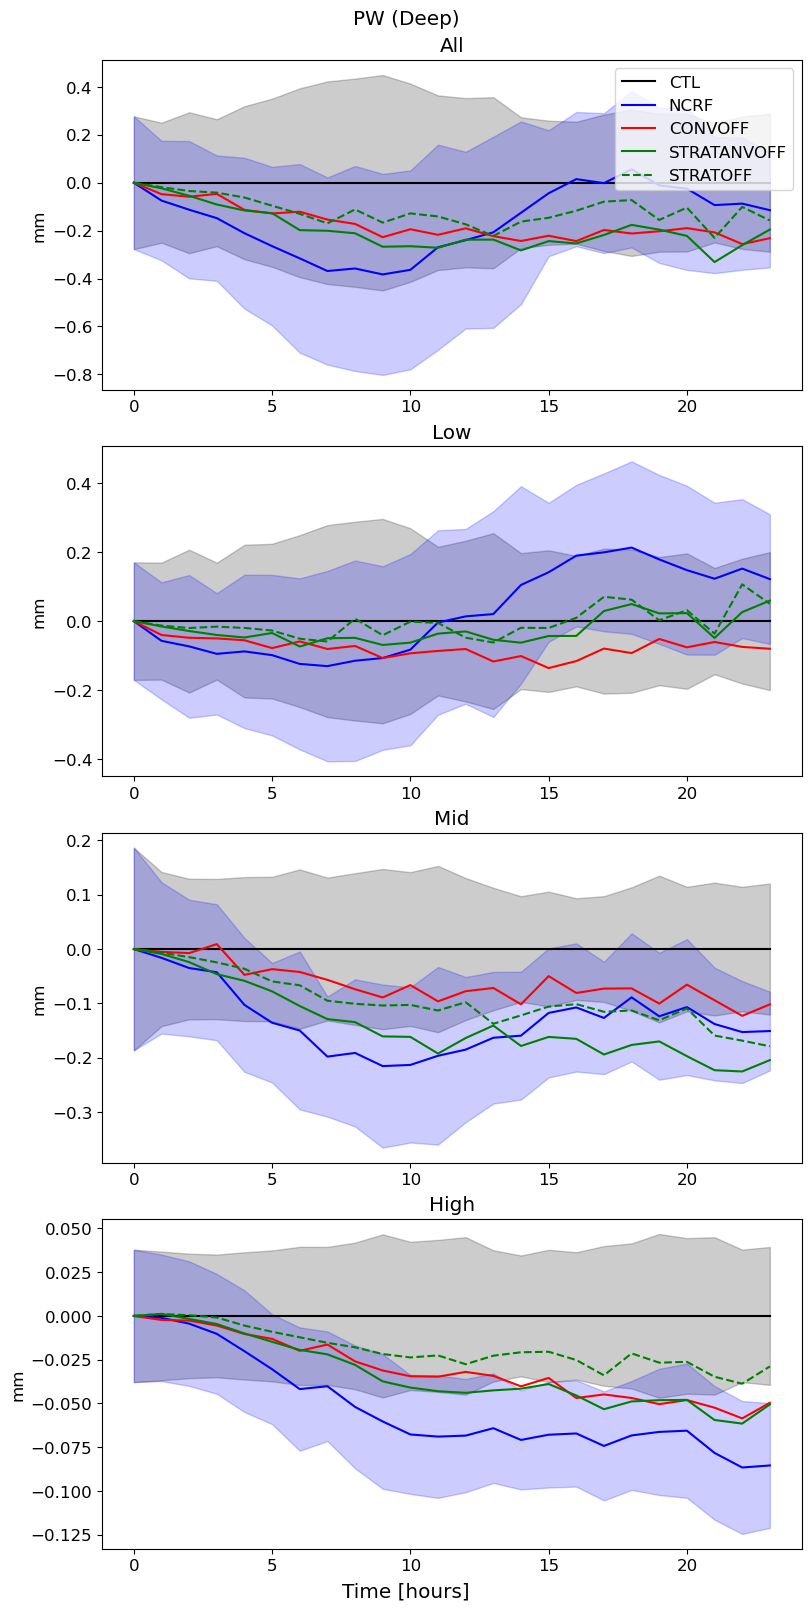

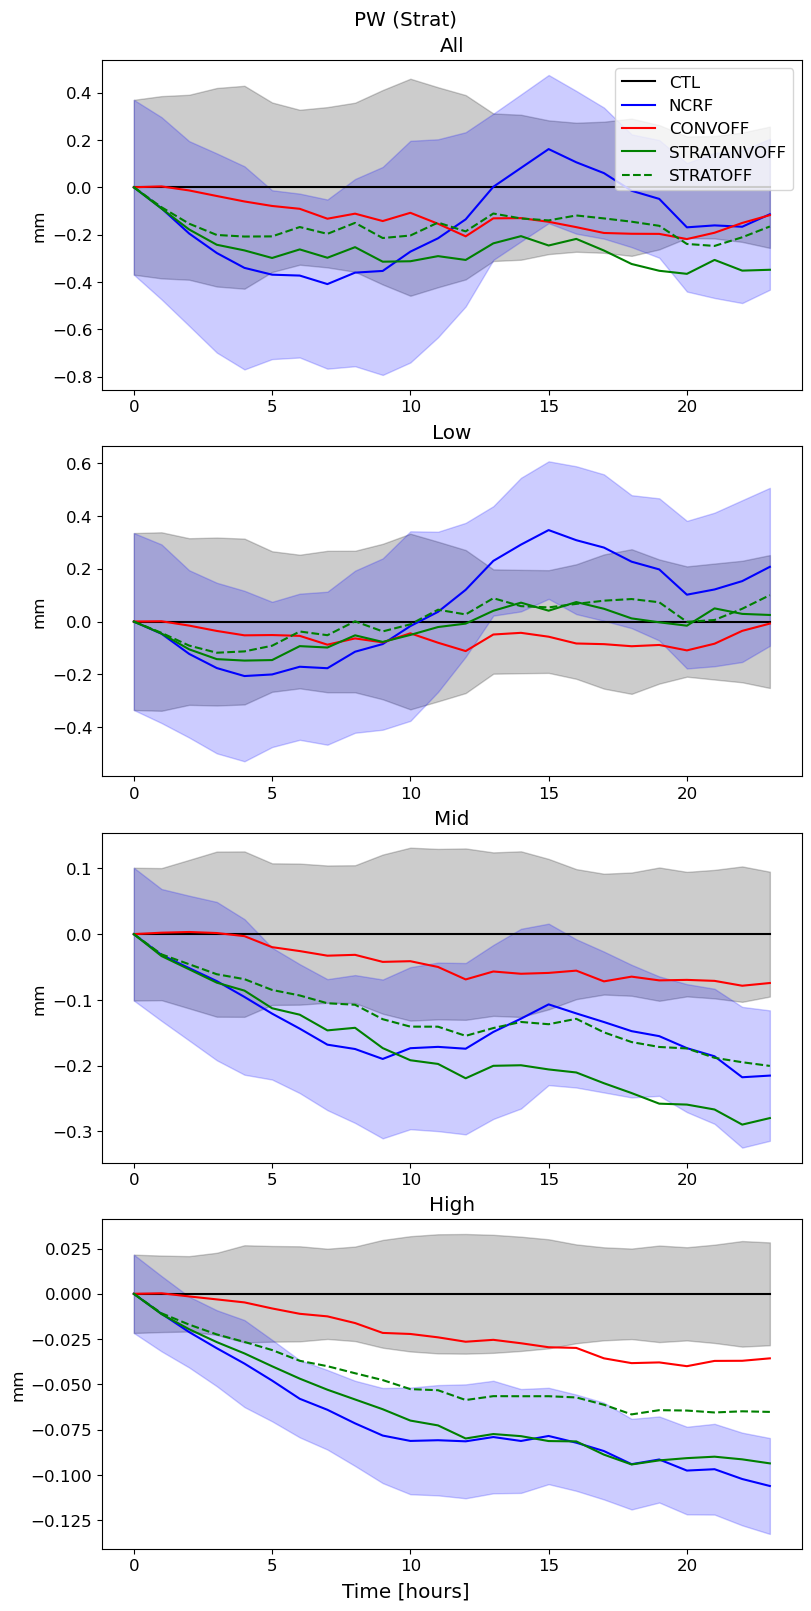

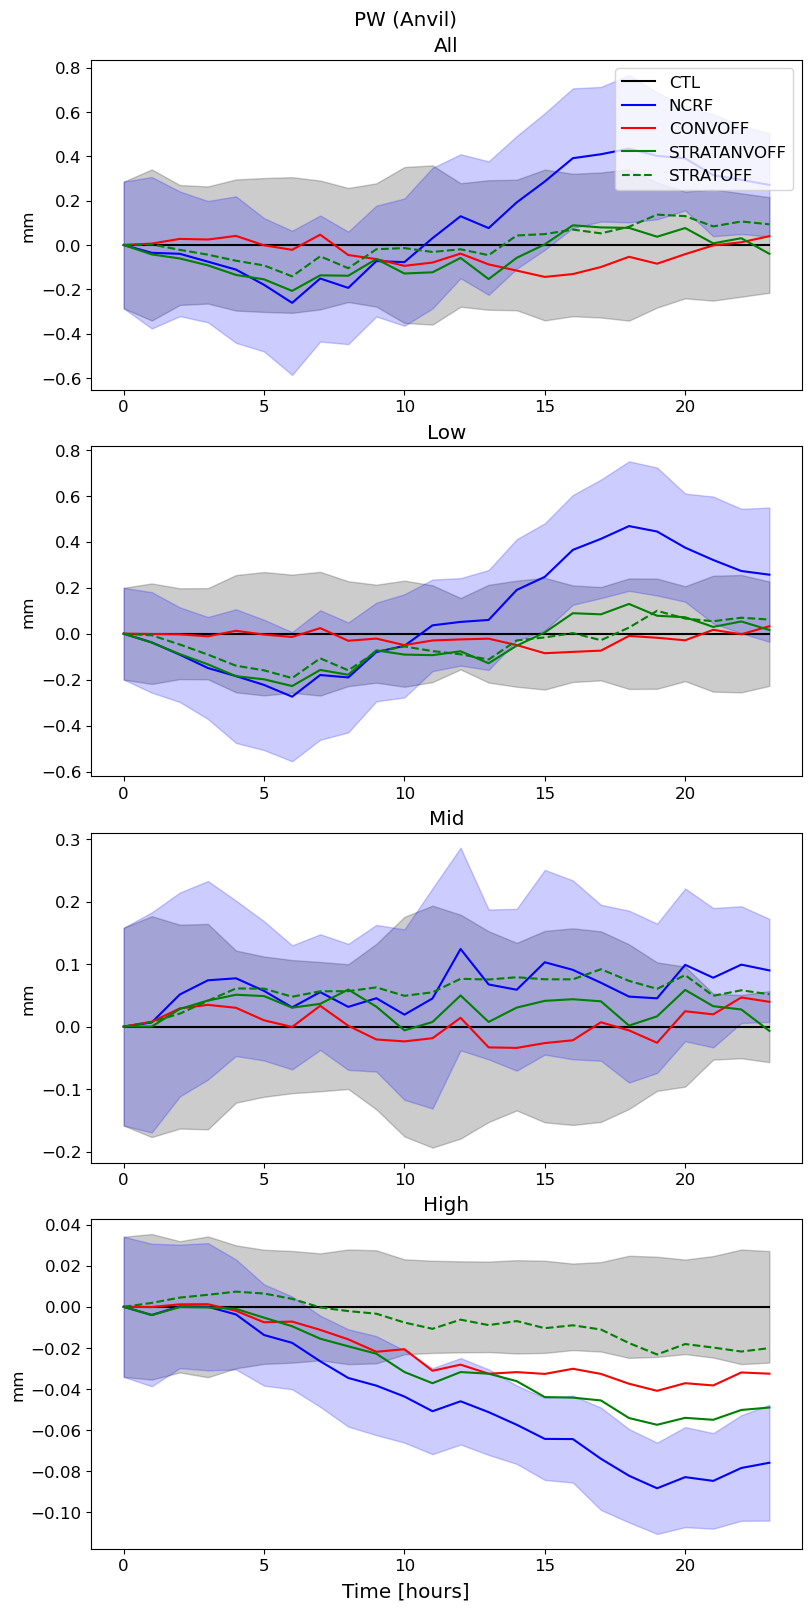

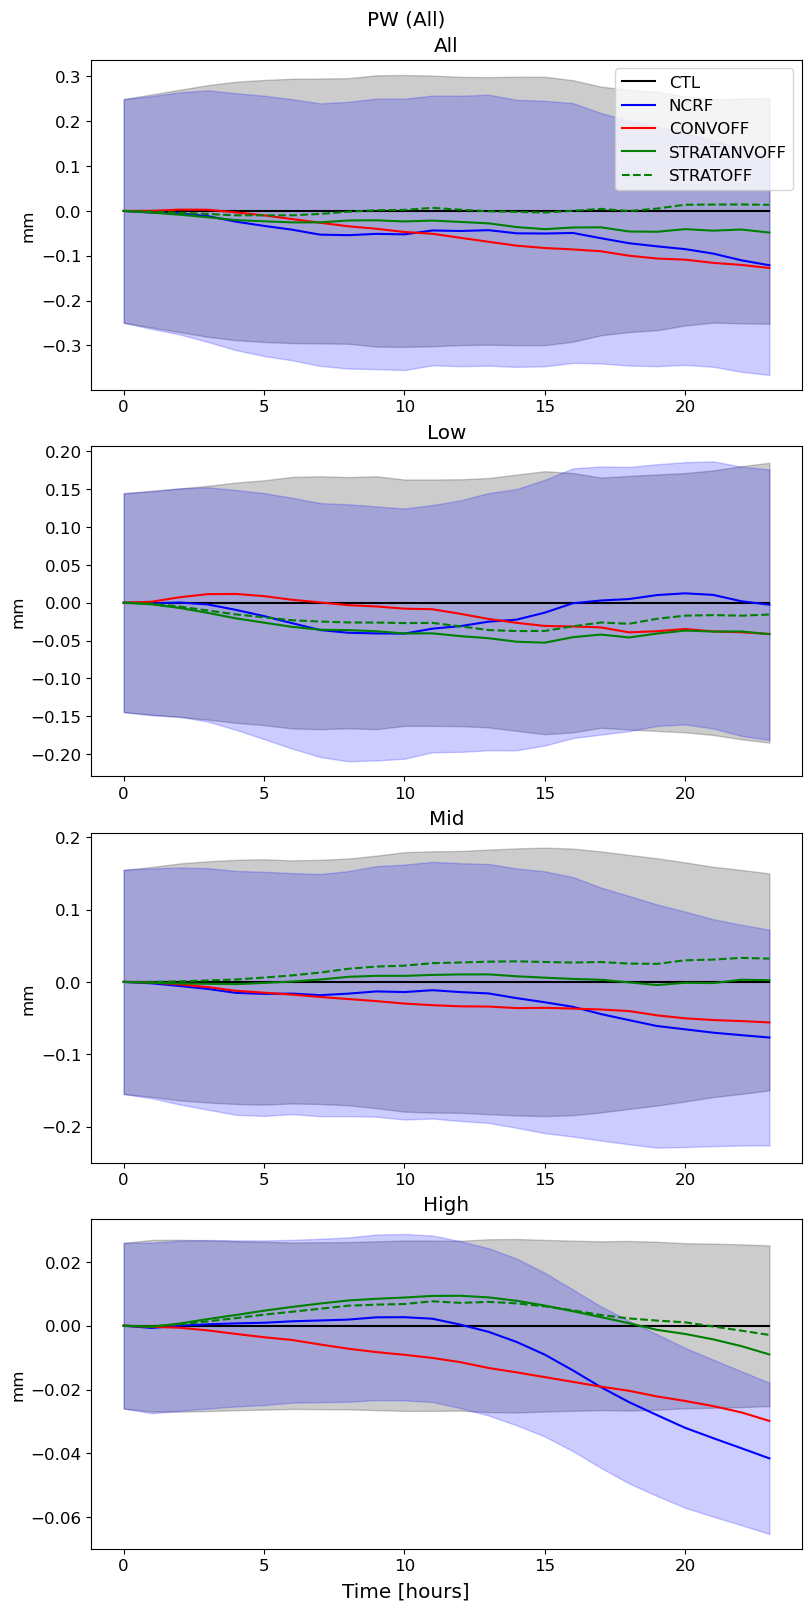

In [26]:
# Vertical integral function
def calc_vint_v2(invar, pres, dp, p_bot, p_top):
    # Note: pres is in hPa, dp in Pa
    g = 9.81 # m/s2
    # p_top = 100 # hPa, integration top
    ik_sum = np.where((pres < p_bot) & (pres >= p_top))
    var_vint = np.sum(invar[...,np.min(ik_sum):np.max(ik_sum)+1], axis=-1)*dp/g
    return var_vint

# Variable list

qv_low = calc_vint_v2(qv, pres, dp, 1100, 700)
qv_mid = calc_vint_v2(qv, pres, dp, 700, 400)
qv_high = calc_vint_v2(qv, pres, dp, 400, 100)
qv_full = calc_vint_v2(qv, pres, dp, 1100, 100)

all_vars = np.array([qv_full, qv_low, qv_mid, qv_high])
nprof = all_vars.shape[0]
subtitles = ['All', 'Low', 'Mid', 'High']
units     = ['mm']*nprof # this creates an array of ['solid'] of size ntest

# all_vars_ensmean = np.mean(all_vars, axis=1)
all_vars_vint = all_vars

for iimean in range(nmean_sel):

    print()
    imean = imean_sel[iimean]

    all_vars_imean = all_vars_vint[...,imean,:]

    # create figure
    fig_x = 8
    fig_y = 16
    fig, ax = plt.subplots(nprof,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column

    fig.suptitle('PW ('+mean_str[imean]+')')
    fig.supxlabel('Time [hours]')

    for iprof in range(nprof):

        pltvar = all_vars_imean[iprof]
        ctl_ensmean = np.mean(pltvar[:,0,:], axis=0)
        pltvar_anom = pltvar - ctl_ensmean[np.newaxis,np.newaxis,:]

        # Plot all sensitivity tests for variable
        for itest in range(ntest):

            # mean, low, high = mean_confidence_interval(pltvar[:,itest,:])
            mean, low, high = mean_confidence_interval(pltvar_anom[:,itest,:])
            ax[iprof].plot(mean, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            # var_smooth = pd.DataFrame(mean)
            # var_smooth = var_smooth.rolling(window=3, center=True, closed='both').mean()
            # ax[iprof].plot(var_smooth, linestyle=linestyle[itest], color=linecolor[itest], label=tests_str[itest])
            if (itest == 0) or (itest == 1):
                xdim = range(0,nt)
                ax[iprof].fill_between(xdim, high, low, alpha=0.2, color=linecolor[itest])
                # low_smooth = pd.DataFrame(low)
                # low_smooth = low_smooth.rolling(window=3, center=True, closed='both').mean()
                # high_smooth = pd.DataFrame(high)
                # high_smooth = high_smooth.rolling(window=3, center=True, closed='both').mean()
                # ax[iprof].fill_between(xdim, np.squeeze(high_smooth), np.squeeze(low_smooth), alpha=0.2, color=linecolor[itest])

        ax[iprof].set_title(subtitles[iprof])
        ax[iprof].set_ylabel(units[iprof])

    ax[0].legend(loc="upper right")

    plt.show()